In [238]:
import pandas as pd
import akshare as ak
import seaborn as sns
import arch
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from arch import arch_model
warnings.filterwarnings('ignore')
sns.set(font='SimHei')
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 
df = ak.stock_zh_a_spot_em()
df.to_excel('example1.xlsx', sheet_name='Sheet1', index=False)

In [239]:
import pandas as pd
import akshare as ak
df=ak.stock_zh_a_hist(symbol='688256', period='daily', start_date='20230701', end_date='20240601', adjust='qfq')
df.to_csv('688256b.csv',index=False)

In [240]:
df['date']=pd.to_datetime(df['日期'])
df=df.set_index('date')

In [241]:
ret=100*df['收盘'].pct_change().dropna()

In [242]:
from statsmodels.tsa.stattools import adfuller #ADF单位根检验
result = adfuller(ret) #不能拒绝原假设，即原序列存在单位根
print(result)

(-11.803081040290593, 9.231692087108753e-22, 1, 219, {'1%': -3.460567372610299, '5%': -2.874829809033386, '10%': -2.573853225954421}, 1217.6758321194948)


划分训练集和预测部分

In [243]:
ret_train=ret[ret.index<'2024-05-01']
ret_test=ret[ret.index>='2024-05-01']

建立简单arch模型，进行arch效应检验

In [244]:
t1=arch.arch_model(ret_train, mean="Constant", vol="ARCH", p=1)
result=t1.fit(disp="off")

In [245]:
result

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                     收盘   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -596.187
Distribution:                  Normal   AIC:                           1198.37
Method:            Maximum Likelihood   BIC:                           1208.28
                                        No. Observations:                  201
Date:                Thu, Jun 20 2024   Df Residuals:                      200
Time:                        01:07:05   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0513      0.328      0.156      0.876 [ -0.591,  0.69

In [246]:
result.arch_lm_test()

ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 20.3787
P-value: 0.1579
Distributed: chi2(15)
WaldTestStatistic, id: 0x23c8221c250

In [247]:
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import shapiro

In [248]:
# 模型优化
def gridsearch(data, p_rng, q_rng):
    top_score, top_results = float('inf'), None
    top_models = []
    for p in range(len(p_rng)):
        for q in range(len(q_rng)):
            model = arch_model(data, vol='GARCH', p=p_rng[p], q=q_rng[q], dist='normal')
            model_fit = model.fit(disp='off')
            resid = model_fit.resid
            st_resid = np.divide(resid, model_fit.conditional_volatility)
            results = evaluate_model(resid, st_resid)
            results['AIC'] = model_fit.aic
            results['params']['p'] = p+1
            results['params']['q'] = q+1
            print(model_fit.aic)
            if results['AIC'] < top_score:
                top_score = results['AIC']
                top_results = results

    top_models.append(top_results)
    return top_models


# 模型评估
def evaluate_model(residuals, st_residuals, lags=50):
    results = {
        'LM_pvalue': None,
        'F_pvalue': None,
        'SW_pvalue': None,
        'AIC': None,
        'params': {'p': None, 'q': None}
    }

    arch_test = het_arch(residuals, nlags=lags)
    shap_test = shapiro(st_residuals)

    results['LM_pvalue'] = [arch_test[1], arch_test[1] < 0.05]
    results['F_pvalue'] = [arch_test[3], arch_test[3] < 0.05]
    results['SW_pvalue'] = [shap_test[1], shap_test[1] < 0.05]

    return results


p_rng = list(range(1, 5)) 
q_rng = list(range(1, 5)) 
top_models = gridsearch(ret_train, p_rng, q_rng)
print('*****************top_models*******************')
print(top_models)

1194.193763381359
1196.1937634329743
1198.193763142871
1203.1364420480008
1192.3024150142885
1194.302414287998
1196.3024147039264
1198.3024147166657
1193.1004177109357
1195.1004173778033
1197.1004171451918
1199.1004172366584
1194.7449188200162
1196.7449187324476
1198.7449189018062
1200.7449188650348
*****************top_models*******************
[{'LM_pvalue': [0.9770064431775917, False], 'F_pvalue': [0.9914091910089826, False], 'SW_pvalue': [2.910626108132419e-06, True], 'AIC': 1192.3024150142885, 'params': {'p': 2, 'q': 1}}]


In [249]:
garch_model_1=arch.arch_model(ret_train,vol='GARCH',p=3,q=7)
garch_result=garch_model_1.fit(disp="off")

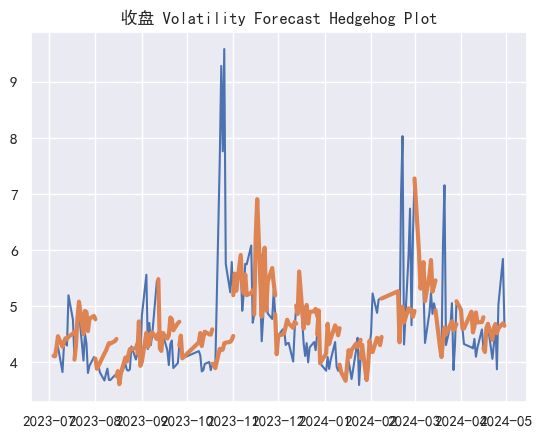

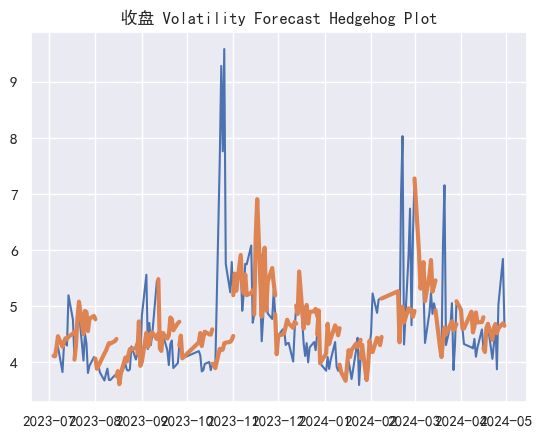

In [250]:
garch_result.hedgehog_plot()

In [251]:
forecasts_train = garch_result.forecast(start=0,horizon=1)
forecasts_train.residual_variance

,h.1
date,
2023-07-04,16.879497
2023-07-05,18.208524
2023-07-06,18.271161
2023-07-07,14.625227
2023-07-10,18.547313
...,...
2024-04-24,15.039139
2024-04-25,25.327877
2024-04-26,34.162099


In [252]:
forecast_test=garch_result.forecast(horizon=len(ret_test))

In [253]:
tmp=forecast_test.residual_variance.dropna().T
tmp2=tmp[tmp.columns[0]].values.tolist()
future=pd.DataFrame(tmp2)
future.columns=['h.1']
future.index=ret_test.index

In [254]:
forecasts_train.residual_variance

,h.1
date,
2023-07-04,16.879497
2023-07-05,18.208524
2023-07-06,18.271161
2023-07-07,14.625227
2023-07-10,18.547313
...,...
2024-04-24,15.039139
2024-04-25,25.327877
2024-04-26,34.162099


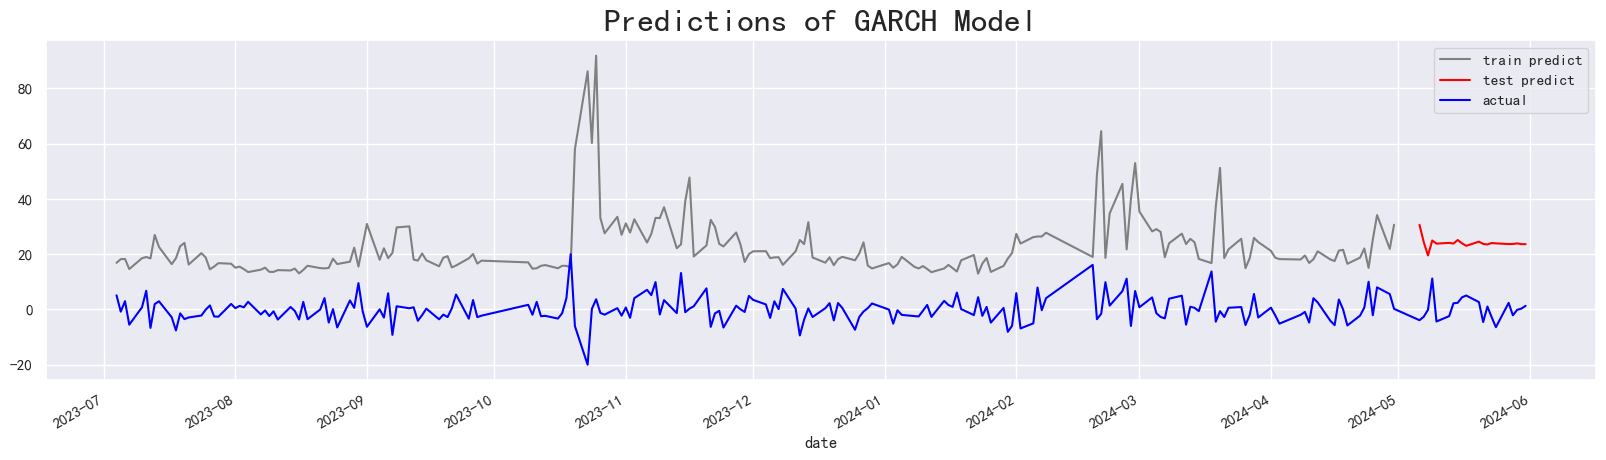

In [255]:
plt.figure(figsize=(20,5))
plt.plot(forecasts_train.residual_variance.index,forecasts_train.residual_variance.values,color='gray')
plt.plot(future.index,future[future.columns[0]],color='red')
ret.plot(color = "blue", zorder = 3)
plt.title("Predictions of GARCH Model", size=24)
plt.legend(['train predict','test predict','actual'])
plt.show()

In [256]:
am = arch_model(ret, vol="arch", p=3, o=0, q=7, dist="skewt")
res = am.fit(disp="off")

In [257]:
forecasts = res.forecast(start=0)
cond_mean = forecasts.mean.dropna()
cond_var = forecasts.variance.dropna()
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

[-2.09536665 -1.39521155]


In [258]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index)

In [259]:
for col in value_at_risk.columns:
    value_at_risk[col]=-value_at_risk[col]

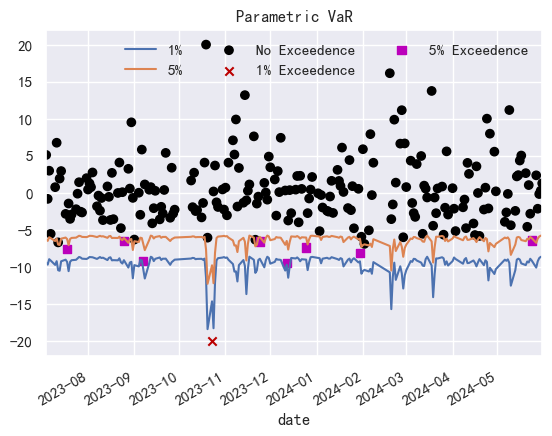

In [260]:
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = ret.copy()
rets_2018.name = "S&P 500 Return"


c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > value_at_risk.loc[idx, "5%"]:
        c.append("#000000")
    elif rets_2018[idx] < value_at_risk.loc[idx, "1%"]:
        c.append("#BB0000")
    else:
        c.append("#BB00BB")
c = np.array(c, dtype="object")
labels = {
    "#BB0000": "1% Exceedence",
    "#BB00BB": "5% Exceedence",
    "#000000": "No Exceedence",
}
markers = {"#BB0000": "x", "#BB00BB": "s", "#000000": "o"}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color],
    )
ax.set_title("Parametric VaR")
leg = ax.legend(frameon=False, ncol=3)

In [261]:
forecasts_train.residual_variance

,h.1
date,
2023-07-04,16.879497
2023-07-05,18.208524
2023-07-06,18.271161
2023-07-07,14.625227
2023-07-10,18.547313
...,...
2024-04-24,15.039139
2024-04-25,25.327877
2024-04-26,34.162099


In [262]:
t=pd.DataFrame(future)
t.columns=['h.1']

In [263]:
vol=forecasts_train.residual_variance._append(t)

In [264]:
vol['ret']=ret

<Axes: xlabel='date'>

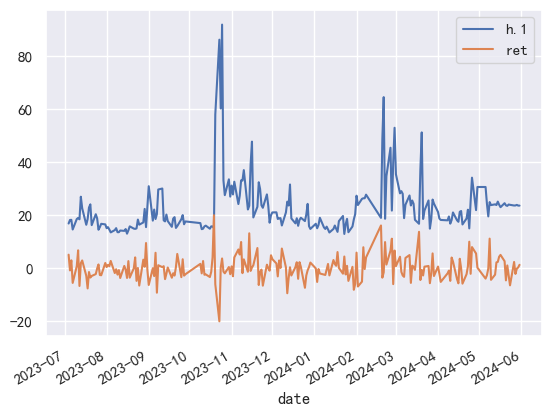

In [265]:
vol.plot()

In [266]:
vol_tmp=vol[vol.index>='2024-05-01']

In [267]:
total=[]
first_price=df['收盘'].values.tolist()[-25]
next_price=first_price
for val in vol_tmp['h.1'].values.tolist():
    next_price=(1+(val/100))*next_price
    total.append(next_price)      

In [268]:
vol_tmp['h.1'].values.tolist()

[30.648539656497448,
 24.362034139571218,
 19.557237774825126,
 24.957131035156824,
 23.831114754557767,
 24.09976659428035,
 23.847431555864933,
 25.13657037498398,
 23.967958331304292,
 23.031792983726003,
 24.542878665881013,
 23.721306848003145,
 23.530391121750327,
 24.041546462818058,
 23.928338256693166,
 23.665607813668057,
 23.685304061842317,
 23.912068702534018,
 23.63738335440122,
 23.630992510624285]

In [269]:
df_tmp=df[df.index>='2024-05-01']
df_tmp['pred_garch']=total
df

,日期,股票代码,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
date,,,,,,,,,,,,
2023-07-03,2023-07-03,688256,187.02,192.54,199.00,181.00,114307,2.160025e+09,9.57,2.41,4.54,4.68
2023-07-04,2023-07-04,688256,190.00,202.41,205.20,187.28,118369,2.349024e+09,9.31,5.13,9.87,4.85
2023-07-05,2023-07-05,688256,199.49,200.80,206.74,196.51,74937,1.511240e+09,5.05,-0.80,-1.61,3.07
2023-07-06,2023-07-06,688256,198.22,206.82,217.80,198.22,109094,2.293471e+09,9.75,3.00,6.02,4.47
2023-07-07,2023-07-07,688256,206.82,195.43,209.60,187.87,93416,1.833783e+09,10.51,-5.51,-11.39,3.83
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,2024-05-27,688256,170.00,175.99,177.60,165.98,98148,1.687678e+09,6.76,2.38,4.09,2.36
2024-05-28,2024-05-28,688256,174.51,172.25,183.00,172.00,80918,1.428303e+09,6.25,-2.13,-3.74,1.94
2024-05-29,2024-05-29,688256,174.30,172.00,178.64,170.11,57707,1.005904e+09,4.95,-0.15,-0.25,1.39


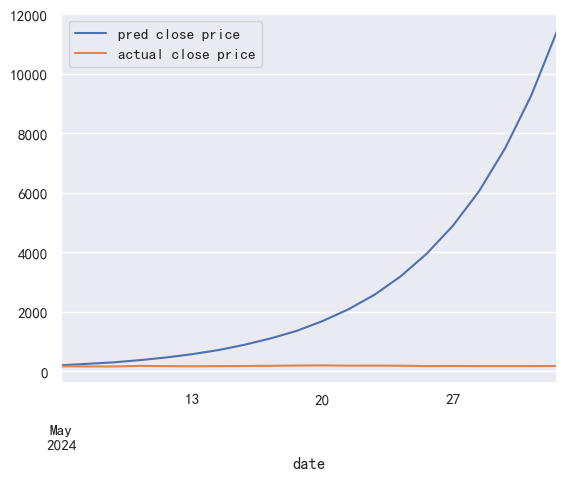

In [270]:
df_tmp['pred_garch'].plot()
df_tmp['收盘'].plot()
plt.legend(['pred close price','actual close price'])